In [1]:
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
import math
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, Layer, ReLU, LeakyReLU
from tensorflow.keras import backend as K
from func import load_model, save_model

2024-06-14 10:02:02.002555: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-14 10:02:02.064360: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
signal_labels = ['extended_sig']

In [3]:
signals_file = ['extended_signal_data.h5']

In [6]:
def create_standardized_distr():
    '''
    returns the standardized distribution for x_train, x_test and x_val for the dense auto encoder
    '''
    with h5py.File('final_form_bkg.h5', 'r') as file:
        X_train = np.array(file['X_train'])
        X_test = np.array(file['X_test'])
        X_val = np.array(file['X_val'])
        
    scaler = StandardScaler()
    scaler.fit(X_train)
    x_train = scaler.transform(X_train)
    x_test = scaler.transform(X_test)
    x_val = scaler.transform(X_val)
    
    signal_data = []

    with h5py.File(signals_file[0], 'r') as file:
        test_data = np.array(np.transpose(file['extended_sig']))
        
    signal_data.append(scaler.transform(test_data))
    
    return x_train, x_test, x_val, signal_data

In [7]:
x_train_std, x_test_std, x_val_std, signal_data = create_standardized_distr()

In [8]:
with h5py.File("bkg_std_distr.h5", "w") as f:

    # Store datasets in the HDF5 file
    f.create_dataset("X_train", data=x_train_std)
    f.create_dataset("X_test", data=x_test_std)
    f.create_dataset("X_val", data=x_val_std)

## Train DAE

In [9]:
input_shape = 156
latent_dimension = 3
num_nodes=[56,8]

In [10]:
#encoder
#inputArray = Input(shape=(input_shape))
inputArray = Input(shape=(input_shape,))
x = Dense(num_nodes[0], use_bias=False)(inputArray)
x = Activation('relu')(x)
x = Dense(latent_dimension, use_bias=False)(x)
encoder = Activation('relu')(x)

#decoder
x = Dense(num_nodes[0], use_bias=False)(encoder)
x = Activation('relu')(x)
decoder = Dense(input_shape)(x)

#create autoencoder
autoencoder = Model(inputs = inputArray, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 156)]             0         
                                                                 
 dense (Dense)               (None, 56)                8736      
                                                                 
 activation (Activation)     (None, 56)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 168       
                                                                 
 activation_1 (Activation)   (None, 3)                 0         
                                                                 
 dense_2 (Dense)             (None, 56)                168       
                                                                 
 activation_2 (Activation)   (None, 56)                0     

In [11]:
autoencoder.compile(optimizer = keras.optimizers.Adam(), loss='mse')

In [12]:
EPOCHS = 10
BATCH_SIZE = 1024

In [13]:
history = autoencoder.fit(x_train_std, x_train_std, epochs = EPOCHS, batch_size = BATCH_SIZE,
                  validation_data=(x_val_std, x_val_std))

Epoch 1/10
1243/1243 [==============================] - 10s 7ms/step - loss: 0.8531 - val_loss: 0.9368
Epoch 2/10
1243/1243 [==============================] - 7s 6ms/step - loss: 0.8141 - val_loss: 0.9115
Epoch 3/10
1243/1243 [==============================] - 7s 6ms/step - loss: 0.7956 - val_loss: 0.8974
Epoch 4/10
1243/1243 [==============================] - 7s 6ms/step - loss: 0.7853 - val_loss: 0.8907
Epoch 5/10
1243/1243 [==============================] - 7s 6ms/step - loss: 0.7767 - val_loss: 0.8894
Epoch 6/10
1243/1243 [==============================] - 7s 6ms/step - loss: 0.7691 - val_loss: 0.8791
Epoch 7/10
1243/1243 [==============================] - 7s 6ms/step - loss: 0.7627 - val_loss: 0.8769
Epoch 8/10
1243/1243 [==============================] - 7s 6ms/step - loss: 0.7572 - val_loss: 0.8716
Epoch 9/10
1243/1243 [==============================] - 7s 6ms/step - loss: 0.7524 - val_loss: 0.8699
Epoch 10/10
1243/1243 [==============================] - 7s 6ms/step - loss: 0.74

In [14]:
model_name = 'std_dae'
model_directory = 'model_directory'
save_model(model_directory+model_name, autoencoder)

### Background prediction

In [15]:
bkg_prediction = autoencoder.predict(x_test_std)

12426/12426 [==============================] - 16s 1ms/step


### Signal Prediction

In [16]:
with h5py.File("sig_std_distr.h5", "w") as f:

    # Store datasets in the HDF5 file
    f.create_dataset("signal_std", data=signal_data)

In [17]:
signal_results = []

signal_prediction = autoencoder.predict(signal_data)
signal_results.append([signal_labels[0], signal_data, signal_prediction])

82/82 [==============================] - 0s 2ms/step


In [18]:
save_file = 'std_dae_data.h5'

In [19]:
with h5py.File(save_file, 'w') as file:
    file.create_dataset('BKG_input', data=x_test_std)
    file.create_dataset('BKG_predicted', data = bkg_prediction)
    file.create_dataset('sig_input', data = signal_results[0][1])
    file.create_dataset('sig_predicted', data = signal_results[0][2])

In [20]:
from func import mse_loss

In [21]:
print(signal_results[0][2])

[[ 1.22992527e+00  4.97301342e-03 -8.47704057e-03 ...  1.23122990e-01
  -3.45078520e-02 -3.18654701e-02]
 [ 2.45540309e+00  1.45400851e-03  1.56125128e-02 ... -5.49080014e-01
  -6.15798794e-02 -7.62287825e-02]
 [ 8.10588837e-01  9.31214355e-03  1.24697629e-02 ... -1.52990580e-01
   9.79797915e-03 -3.04191168e-02]
 ...
 [ 6.15024686e-01 -5.09042107e-03 -2.45001540e-03 ...  1.71571314e-01
  -1.80131476e-02  7.05893151e-03]
 [ 1.77753234e+00 -1.04055274e-04  8.14183578e-02 ... -1.36118770e+00
  -5.38270883e-02 -8.89220238e-02]
 [ 8.23592305e-01 -2.19652712e-01  4.28178087e-02 ...  4.06807721e-01
  -6.88865840e-01  5.51229656e-01]]


In [22]:
# compute loss value (true, predicted)
total_loss = []
total_loss.append(mse_loss(x_test_std, bkg_prediction.astype(np.float32)).numpy())
for i, signal_X in enumerate(signal_data):
    total_loss.append(mse_loss(signal_X, signal_results[i][2].astype(np.float32)).numpy())

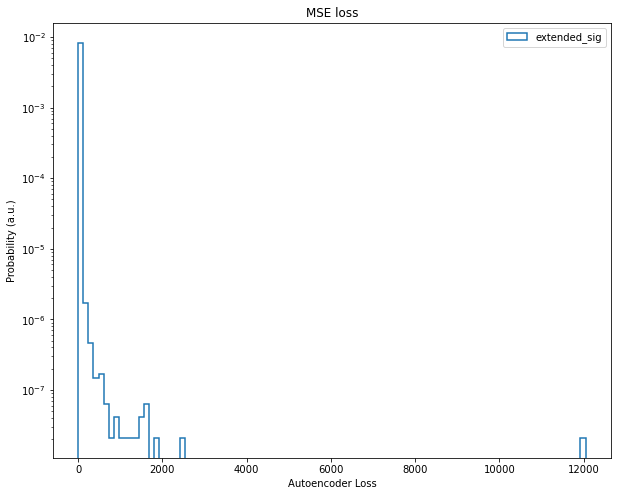

In [23]:
bin_size=100

plt.figure(figsize=(10,8))
for i, label in enumerate(signal_labels):
    plt.hist(total_loss[i], bins=bin_size, label=label, density = True, histtype='step', fill=False, linewidth=1.5)
plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.title('MSE loss')
plt.legend(loc='best')
plt.savefig("Std_dae_3_layers_loss.png")
plt.show()